# General plots for the paper

In [9]:
# Packages first plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import pickle
import os 

In [2]:
# set seed
rng = np.random.default_rng(42)

## 2-D density plot

In [14]:
# create contour plot for two 2-D gaussians same mean, one with correlation between the variables and one without 
# Values based Kucukelbir et al. 2016 Figure 4
mu = np.array([1.0, 2.0])
cov1 = np.array([[0.13, 0], [0, 0.14]])
cov2 = np.array([[0.28, 0.2], [0.2, 0.31]])

In [15]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


In [16]:
is_pos_def(cov2)

True

In [17]:
# generate samples from the multivariate normal distribution
x1 = rng.multivariate_normal(mu, cov1, size=5000)
x2 = rng.multivariate_normal(mu, cov2, size=5000)

In [18]:
x2.shape

(5000, 2)

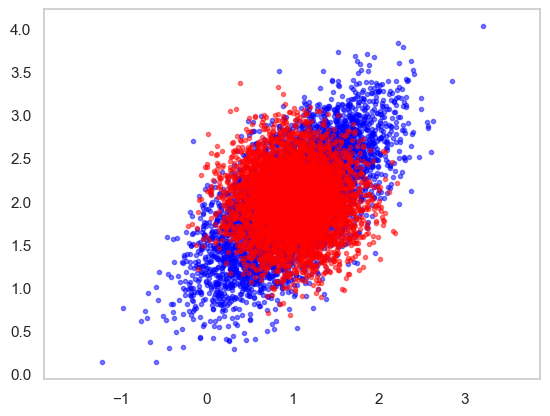

In [19]:
plt.plot(x2[:, 0], x2[:, 1], '.', alpha=0.5, color="blue")
plt.plot(x1[:, 0], x1[:, 1], '.', alpha=0.5, color="red")
plt.axis('equal')
plt.grid()
plt.show()

In [20]:
cmap1 = matplotlib.colormaps.get_cmap("Blues")
c1 = cmap1(0.5)[:3]
cmap2 = matplotlib.colormaps.get_cmap("Reds")
c2 = cmap2(0.5)[:3]

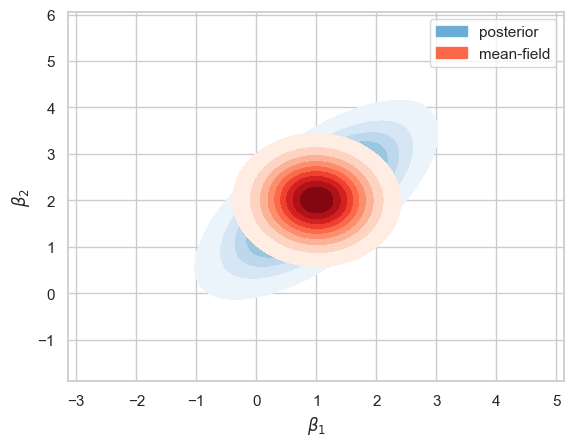

In [21]:
# create density plot
fig = plt.figure()

sns.set_theme(style="whitegrid")

sns.kdeplot(x=x2[:,0], y=x2[:,1], cmap="Blues", fill=True, bw_adjust=5)
sns.kdeplot(x=x1[:,0], y=x1[:,1], cmap="Reds", fill=True, bw_adjust=5)

red_patch = mpatches.Patch(color=c1, label='posterior')
blue_patch = mpatches.Patch(color=c2, label='mean-field')
plt.legend(handles=[red_patch, blue_patch])

plt.xlabel(r'$\beta_{1}$')
plt.ylabel(r'$\beta_{2}$')
plt.show()

In [22]:
current_directory = os.getcwd()
path = "../thesis/assets/plots"
filename = "plot1.pdf"  

# Create the full path to the folder
folder_path = os.path.join(current_directory, path)

# Create the full path to the file
full_filepath = os.path.join(folder_path, filename)

# safe figure to assets/plots
fig.savefig(full_filepath)

## ELBO convergence plots 

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

rng = np.random.default_rng(42)

In [2]:
# Sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_sigma = 1.0

# Data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
eps = rng.normal(scale=true_sigma, size=n)
response_vec = X_mat @ true_beta + eps

# Data to plot the linear regression line
x_plot = np.linspace(0, 1, num=200)
X_plot = np.column_stack([np.ones(200), x_plot])

In [3]:
# Set up design matrix 
X = tiger.Obs(name="X_loc")
X.fixed(data = x0)

# Set up hyperparameters
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# Set up hyperparameters for the scale
sigma_a = tiger.Hyper(0.01, name="a")
sigma_b = tiger.Hyper(0.01, name="b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)

# Use paramter param_space="positive" to transform sigma into unconstrained space  
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta=beta)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [4]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [5]:
q1 = bbvi.Bbvi(graph=graph)
q1.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=27,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=2500)

(Array(-739.82935, dtype=float32),
 {'beta': {'loc': Array([0.9720517, 1.932893 ], dtype=float32),
   'cov': Array([[ 0.00952932, -0.01153036],
          [-0.01153036,  0.02479743]], dtype=float32)},
  'sigma': {'loc': Array([0.01591269], dtype=float32),
   'cov': Array([[0.00587851]], dtype=float32)}})

In [6]:
q2 = bbvi.Bbvi(graph=graph)
q2.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=5,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=2500)

(Array(-773.3842, dtype=float32),
 {'beta': {'loc': Array([0.9793757, 1.9178854], dtype=float32),
   'cov': Array([[ 0.00968256, -0.01182523],
          [-0.01182523,  0.02469354]], dtype=float32)},
  'sigma': {'loc': Array([0.02707044], dtype=float32),
   'cov': Array([[0.00602862]], dtype=float32)}})

In [7]:
q3 = bbvi.Bbvi(graph=graph)
q3.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=15,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=2500)

(Array(-748.5525, dtype=float32),
 {'beta': {'loc': Array([0.9759853, 1.8952211], dtype=float32),
   'cov': Array([[ 0.01022209, -0.01164773],
          [-0.01164773,  0.02516624]], dtype=float32)},
  'sigma': {'loc': Array([0.03570153], dtype=float32),
   'cov': Array([[0.00859779]], dtype=float32)}})

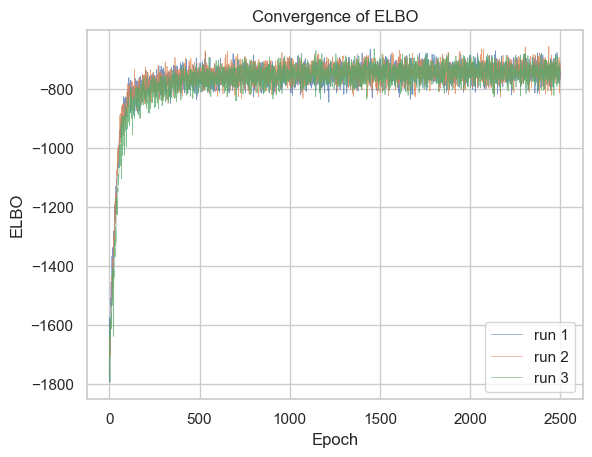

In [21]:
# Create the plot
fig = plt.figure()

sns.set_theme(style="whitegrid")

plt.plot(q1.elbo_hist["epoch"], q1.elbo_hist["elbo"], alpha = 0.75, linewidth=0.5, label="run 1")
plt.plot(q2.elbo_hist["epoch"], q2.elbo_hist["elbo"], alpha = 0.75, linewidth=0.5, label="run 2")
plt.plot(q3.elbo_hist["epoch"], q3.elbo_hist["elbo"], alpha = 0.75, linewidth=0.5, label="run 3")
plt.title("Convergence of ELBO")
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.legend()
plt.show()

In [19]:
current_directory = os.getcwd()
path = "../thesis/assets/plots"
filename = "plot2.pdf"  

# Create the full path to the folder
folder_path = os.path.join(current_directory, path)

# Create the full path to the file
full_filepath = os.path.join(folder_path, filename)

# safe figure to assets/plots
fig.savefig(full_filepath)

## Pickle to store more complex data later on

In [158]:
# Specify the filename for exporting the object
current_directory = os.getcwd()
path = "../thesis/assets/plots"
filename = "data1.pickle"

# Create the full path to the folder
folder_path = os.path.join(current_directory, path)

# Create the full path to the file
full_filepath = os.path.join(folder_path, filename)

full_filepath

'/Users/SebLorek/Desktop/uni/master_statistics/semester_4/master_thesis/liesel-bbvi/playground/../thesis/assets/plots/plot1.pickle'

In [161]:
# Export the object using pickle
with open(filename, "wb") as file:
    pickle.dump(data, full_filepath)

TypeError: file must have a 'write' attribute